In [130]:
#hide
# !pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [131]:
#hide
from fastbook import *
from fastai.vision.widgets import *
from fastai.vision.all import *

In [132]:
key = os.environ.get('AZURE_SEARCH_KEY', '187570e379e046a4bc848c57e5c5c952')

In [133]:
def search_images_bing(key, term, max_images: int = 200, **kwargs):    
     params = {'q':term, 'count':max_images}
     headers = {"Ocp-Apim-Subscription-Key":key}
     search_url = "https://api.bing.microsoft.com/v7.0/images/search"
     response = requests.get(search_url, headers=headers, params=params)
     response.raise_for_status()
     search_results = response.json()    
     return L(search_results['value'])

In [134]:
results = search_images_bing(key, 'nike')
ims = results.attrgot('content_url')
len(ims)

150

In [135]:
#hide
ims = ['https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQ1rXCVqvOJE7cPSB0-PqmX3ab-HqSLbiY61Q&usqp=CAU']

In [136]:
dest = 'images/nike.jpg'
download_url(ims[0], dest)

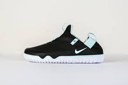

In [137]:
im = Image.open(dest)
im.to_thumb(128,128)

In [141]:
shoes_types = ['nike','adidas','reebok']
path = Path('shoes')

In [142]:
if not path.exists():
    print('a')
    path.mkdir()
    for o in shoes_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} shoes')
        download_images(dest, urls=results.attrgot('contentUrl'))

a


In [143]:
fns = get_image_files(path)
fns

(#446) [Path('shoes/nike/00000002.jpeg'),Path('shoes/nike/00000000.jpg'),Path('shoes/nike/00000004.jpg'),Path('shoes/nike/00000008.jpg'),Path('shoes/nike/00000001.jpg'),Path('shoes/nike/00000006.jpg'),Path('shoes/nike/00000009.jpg'),Path('shoes/nike/00000003.jpg'),Path('shoes/nike/00000011.jpg'),Path('shoes/nike/00000015.jpg')...]

In [144]:
failed = verify_images(fns)
failed

(#7) [Path('shoes/nike/00000007.jpg'),Path('shoes/nike/00000024.jpg'),Path('shoes/nike/00000062.jpg'),Path('shoes/nike/00000133.jpg'),Path('shoes/adidas/00000004.jpg'),Path('shoes/adidas/00000088.jpg'),Path('shoes/reebok/00000010.jpg')]

In [145]:
failed.map(Path.unlink);

In [146]:
shoes = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2),
    get_y=parent_label,
    item_tfms=Resize(128))

In [147]:
dls = shoes.dataloaders(path)

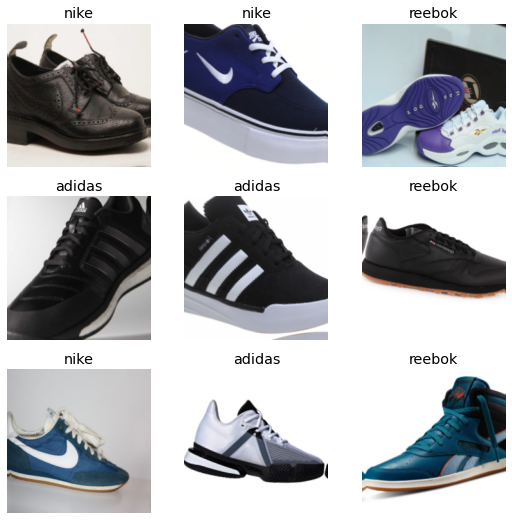

In [148]:
shoes = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2),
    get_y=parent_label,
    item_tfms=RandomResizedCrop(224, min_scale=0.8),
    batch_tfms=aug_transforms())
dls = shoes.dataloaders(path)
dls.show_batch()

In [149]:
learn = cnn_learner(dls, resnet50, loss_func=CrossEntropyLossFlat(),metrics=error_rate)
learn.fine_tune(100)

epoch,train_loss,valid_loss,error_rate,time
0,1.709472,0.904131,0.356322,00:11


/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


epoch,train_loss,valid_loss,error_rate,time
0,0.727844,0.922439,0.367816,00:11
1,0.586445,0.783698,0.310345,00:12
2,0.515890,0.630702,0.252874,00:12
3,0.445878,0.536738,0.206897,00:12
4,0.394033,0.533696,0.195402,00:11
5,0.352122,0.553397,0.195402,00:12
6,0.308116,0.569653,0.183908,00:12
7,0.271519,0.594541,0.137931,00:11
8,0.237003,0.634669,0.149425,00:11
9,0.206471,0.665432,0.172414,00:12


/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:951: U

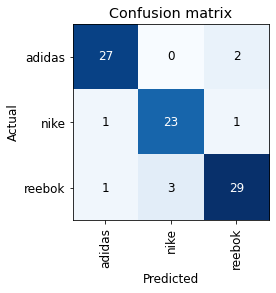

In [150]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

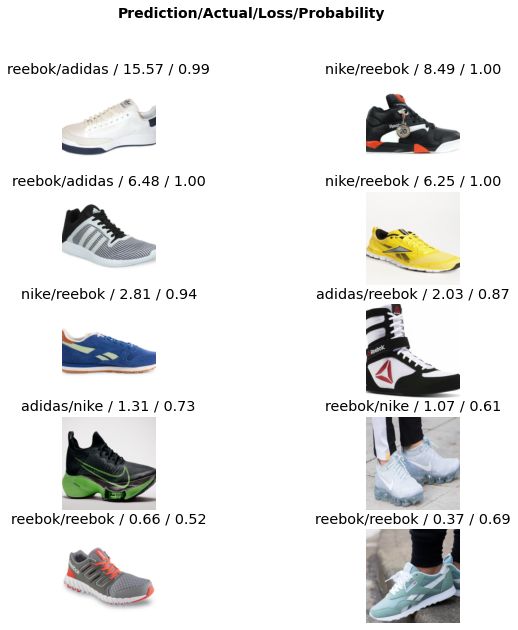

In [151]:
interp.plot_top_losses(10, nrows=5,figsize=(10,10))
#가장 손실값이 높은 샘플

In [152]:
#hide_output
cleaner = ImageClassifierCleaner(learn)
cleaner

/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [153]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [158]:
learn.export()

In [159]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [160]:
learn_inf = load_learner(path/'export.pkl')

In [161]:
learn_inf.predict('images/nike.jpg')

('nike', TensorImage(1), TensorImage([1.6492e-01, 8.3508e-01, 2.5152e-06]))

In [162]:
learn_inf.dls.vocab

['adidas', 'nike', 'reebok']

# App

In [163]:
#hide_output
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [164]:
pred,pred_idx,probs = learn_inf.predict(img)

In [165]:
lbl_pred = widgets.Label()
lbl_pred.value = 'Pleased choose an image'
btn_run = widgets.Button(description='Classify')
btn_upload = widgets.FileUpload()

In [166]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

## VBox

In [167]:
VBox([widgets.Label('Select your shoes!'), 
      btn_upload, btn_run, out_pl, lbl_pred])